# Vaporization Properties
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 3 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 10 February 2020.

The objective of this tutorial is to show how Cantera can be used to access the properties that are needed to perform calculations that involve a liquid-to-vapor phase change, as in droplet vaporization problems. We will use two of Cantera's built-in fluid definitions (`Water()` and `Heptane()`) for liquid-vapor two-phase properties of pure substances. Then for an ideal-gas-mixture vapor phase, we will use Cantera's `Solution()` object as in previous tutorial Notebooks, with thermodynamic properties from seiser.cti.

The file "seiser.cti" (provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in the Chapter 2 Notebooks before working through this Notebook.

## 1. Motivation and background

In many practical combustion systems, fuel is introduced as a liquid, which must vaporize and mix with oxygen from the ambient air before combustion can take place. Fuel vaporization can then be a rate-controlling process in combustion.

Droplet vaporization is introduced in Chapter 3 of Turns 4th ed., and is discussed further in Chapter 10. As shown in Chapter 3, central to determining the rate at which a liquid vaporizes is the accurate determination of the physical properties of the liquid and of the gas mixture into which the liquid vaporizes. In particular, we need the *saturation pressure* $P_{sat}$ of the vaporizing substance at the temperature at which the liquid is vaporizing, and we need the *binary diffusivity* $ \mathcal D_{AB} $ of the freshly vaporized substance with respect to the ambient medium. The other properties are ones with which you should be familiar already. Approaches to estimate the necessary properties are shown in the examples in Chapter 3. In this Notebook, it is shown how $P_{sat}$ and $ \mathcal D_{AB} $ can be determined using Cantera.

## 2. Two-phase (liquid-vapor) pure fluids in Cantera

Liquid-vapor properties are pre-defined for several pure fluids in Cantera. We worked with one of these ([`Water()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/importing.html#cantera.Water)) in tutorial Notebook 2_5_Heating_value, and several other [`Pure Fluid Phases`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/importing.html#pure-fluid-phases) are available. Here we will work with two, as examples: water and n-heptane.

In [1]:
# access modules
tplotlib.import cantera as ct
import numpy as np
import mapyplot as plt

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [ ]:
# define two pure fluids, using Cantera's built-in "Water" and "Heptane" objects
water   = ct.Water()
heptane = ct.Heptane()

# list all available attributes for "water" - the same attributes are available for "heptane"
dir(water)

Of particular interest for present purposes are the [`P_sat`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/thermo.html#cantera.ThermoPhase.P_sat) and [`T_sat`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/thermo.html#cantera.ThermoPhase.T_sat) attributes, which give, respectively, the saturation pressure (Pa) at the current temperature and the saturation temperature (K) at the current pressure.

Currently "water" and "heptane" are in their default states: a temperature of 300 K, a pressure of 1 atm, and a vapor fraction of zero (pure liquid). This can be seen as follows:

In [3]:
# report the current temperature, pressure, and vapor fraction of "water"
water.TPX

(300.0, 101324.99996785645, 0.0)

In [4]:
# report the current temperature, pressure, and vapor fraction of "heptane"
heptane.TPX

(300.0, 101324.9998998493, 0.0)

## 3. Saturation pressures

The *saturation pressure* at any temperature is readily accessed, by setting the temperature to the desired value and using `P_sat`. 

It is also of interest to compare this direct approach for finding the saturation pressure with the approximate method that is used in Examples 3.1 and 3.2 of Turns 4th ed. There the Clausius-Clapeyron equation (Equation 2.19) is integrated to estimate the saturation pressure at a particular temperature, using the known saturation pressure at a different temperature: specifically, at a temperature corresponding to the one-atmosphere boiling point of the liquid of interest. Key assumptions in the Clausius-Clapeyron equation are that the specific volume of the liquid phase is negligible compared with that of the vapor phase, that the vapor behaves as an ideal gas, and that the enthalpy of vaporization is constant. The integrated form of the Clausius-Clapeyron equation is given in Example 3.1.

At one atmosphere, the boiling points of water and of n-heptane are 373.15 K and 371.55 K, respectively (see Table B.1 of Turns 4th ed. for n-heptane). Since "water" and "heptane" are both currently at a pressure of 1 atm, their saturation temperatures are equal to their respective boiling temperatures:

In [5]:
# save the 1-atm boiling temperatures of water and of n-heptane
T_boil_water   = water.T_sat
T_boil_heptane = heptane.T_sat

T_boil_water , T_boil_heptane

(373.1772329354819, 371.5605847211116)

These are equal to the expected values, to within four significant figures.

Next, we need the enthalpies of vaporization of water and n-heptane. We will do that for a pressure of 1 atm and a temperature that is equal to the boiling temperature for each liquid:

In [6]:
# set the states to correspond to pure liquid, at 1 atm and the boiling temperature
water.TX   = T_boil_water   , 0.
heptane.TX = T_boil_heptane , 0.

# save the enthalpies of the pure liquids
h_liq_water   = water.h
h_liq_heptane = heptane.h

# reset the states to correspond to pure vapor, still at 1 atm and the boiling temperatures
water.TX   = None , 1.
heptane.TX = None , 1.

# save the enthalpies of the pure vapors
h_vap_water   = water.h
h_vap_heptane = heptane.h

# compute the enthalpies of vaporization at 1 atm and at the boiling temperature
h_fg_water   = h_vap_water   - h_liq_water
h_fg_heptane = h_vap_heptane - h_liq_heptane

h_fg_water , h_fg_heptane

(2256972.321848903, 317933.53405848425)

These are in SI units (J/kg). The n-heptane value is very close to the value given in Table 3.1; note that the units there are kJ/kg.

Now let's define a function that estimates the saturation pressure at a specified temperature using the Clausius-Clapeyron equation:

In [7]:
# define a function that estimates the saturation pressure (Pa) at a given temperature using the Clausius-Clapeyron equation
# this requires knowledge of the saturation pressure at one temperature, the enthalpy of vaporization, and the
#   molecular weight of the substance of interest
# T (K) is the temperature at which the saturation pressure estimate is desired
# T_ref (K) and P_ref (Pa) are a known saturation temperature and saturation pressure pair for the substance of interest
# h_fg (J/kg) is the enthalpy of vaporization for the substance of interest (assumed constant)
# MW (kg/kmol) is the molecular weight of the substance of interest
def ClausClap(T,T_ref,P_ref,h_fg,MW):
    arg   = h_fg*MW*( 1./T - 1./T_ref ) / ct.gas_constant
    P_sat = P_ref*np.exp(-arg)    
    return P_sat

We compare the values of the saturation pressures from the properties in Catera's `Water` and `Heptane` objects with those from the Clausius-Clapeyron equation. Note that the value of the saturation pressure from the Clausius-Clapeyron equation must be equal to that from the Cantera properties at the 1 atm boiling temperature, since we are using that as our reference in the Clausius-Clapeyron equation. 

In [8]:
# specify the temperature range and increment
tmin  = 300.
tmax  = 451.
delt  =   1.

# define arrays
temps = np.arange(tmin,tmax,delt)
nt    = len(temps)

P_sat_water      = np.zeros(nt) # from Cantera properties
P_sat_water_CC   = np.zeros(nt) # from Clausius-Clapeyron
P_sat_heptane    = np.zeros(nt) # from Cantera properties
P_sat_heptane_CC = np.zeros(nt) # from Clausius-Clapeyron

# compute saturation pressures as functions of temperature
for i , temp in enumerate(temps):
    P_sat_water_CC[i]   = ClausClap(temp,T_boil_water  ,ct.one_atm,h_fg_water  ,water.mean_molecular_weight  )
    P_sat_heptane_CC[i] = ClausClap(temp,T_boil_heptane,ct.one_atm,h_fg_heptane,heptane.mean_molecular_weight)
    water.TX            = temp , None
    P_sat_water[i]      = water.P_sat
    heptane.TX          = temp , None
    P_sat_heptane[i]    = heptane.P_sat
#    print(temp,P_sat_water,P_sat_water_CC,P_sat_heptane,P_sat_heptane)

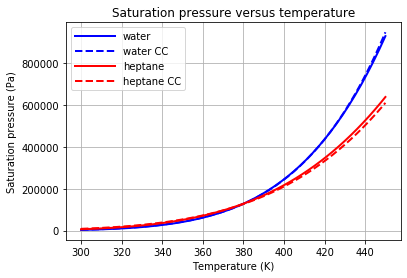

In [9]:
# plot saturation pressures versus temperature
fig, ax = plt.subplots()
ax.plot(temps, P_sat_water,      label='water',      linestyle='solid',  color='blue', lw=2)
ax.plot(temps, P_sat_water_CC,   label='water CC',   linestyle='dashed', color='blue', lw=2)
ax.plot(temps, P_sat_heptane,    label='heptane',    linestyle='solid',  color='red',  lw=2)
ax.plot(temps, P_sat_heptane_CC, label='heptane CC', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Saturation pressure (Pa)',
       title ='Saturation pressure versus temperature')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Psat_vs_T.pdf")

To more clearly see the differences in saturation pressures between the Cantera properties and the Clausius-Clapeyron equation, we plot the difference directly, as a percent with respect to 1 atm pressure:

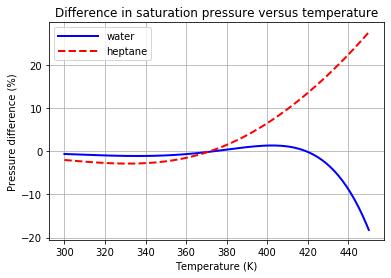

In [10]:
# plot differences in saturation pressures versus temperature
fig, ax = plt.subplots()
ax.plot(temps, 100.*(P_sat_water  -P_sat_water_CC)  /ct.one_atm, label='water',   linestyle='solid',  color='blue', lw=2)
ax.plot(temps, 100.*(P_sat_heptane-P_sat_heptane_CC)/ct.one_atm, label='heptane', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Pressure difference (%)',
       title ='Difference in saturation pressure versus temperature')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Psat_diff_vs_T.pdf")

For temperatures between ambient (300 K) and the boiling point, the differences are small. The differences then increase with increasing temperature above the boiling point. Again, it is important to note that the difference must be equal to zero for each fluid at its 1 atm boiling temperature, since we took that as our reference in the Clausius-Clapeyron equation. 

## 4. Binary diffusivities

A second key property that influences vaporization rates, and that we have not seen up to this point in our tutorial Notebooks, is the *binary diffusivity* of the vaporized substance with respect to the surrounding gas-phase medium. For this, we define a gas mixture using Cantera's `Solution()` object, as we have done in previous tutorial Notebooks. Since we are using n-heptane as an example here, we need a Cantera input data file that includes properties for gas-phase n-heptane. Here we use seiser.cti for that purpose:

In [11]:
# define a gas mixture based on seiser.cti
# the file "seiser.cti" must be present in subdirectory "data" below the current working directory
gas = ct.Solution('data/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


A first observation is that there are discontinuities in the thermodynamic properties for at least one species at its mid-point temperature; see tutorial Notebook Getting_started_with_Cantera. We will proceed without attempting to correct this, under the assumption that it will not cause any numerical problems or introduce any significant inaccuraccies for our purposes. In fact, that is the case.

How many species are considered in seiser.cti?

In [12]:
# print the number of species that is considered in seiser.cti
gas.n_species

160

In [13]:
# print the species names
gas.species()

[<Species n2>,
 <Species ch3>,
 <Species h>,
 <Species ch4>,
 <Species h2>,
 <Species oh>,
 <Species h2o>,
 <Species o>,
 <Species c2h6>,
 <Species c2h5>,
 <Species hco>,
 <Species co>,
 <Species co2>,
 <Species o2>,
 <Species h2o2>,
 <Species ho2>,
 <Species c2h4>,
 <Species ch3oh>,
 <Species ch2oh>,
 <Species ch3o>,
 <Species ch2o>,
 <Species c2h2>,
 <Species c2h3>,
 <Species c2h>,
 <Species hcco>,
 <Species ch2>,
 <Species ch>,
 <Species ch2co>,
 <Species ch2(s)>,
 <Species pc2h4oh>,
 <Species ch3co>,
 <Species ch3cho>,
 <Species c3h5-s>,
 <Species c3h4-p>,
 <Species c3h5-a>,
 <Species c3h6>,
 <Species c3h4-a>,
 <Species ch3chco>,
 <Species c3h5-t>,
 <Species c4h6>,
 <Species nc3h7>,
 <Species ic3h7>,
 <Species c3h8>,
 <Species c5h9>,
 <Species c4h7>,
 <Species c4h8-1>,
 <Species sc4h9>,
 <Species pc4h9>,
 <Species ch3coch3>,
 <Species ch3coch2>,
 <Species c2h5co>,
 <Species c2h5cho>,
 <Species c5h10-1>,
 <Species ch2cho>,
 <Species c5h11-1>,
 <Species c5h11-2>,
 <Species c2h5o>,
 <

Note that in this input data file, the species names are in lower case. The first species listed is diatomic nitrogen ("n2"). The name assigned to water here is "h2o" and to n-heptane is "nc7h16". We can find the corresponding species indices as follows: 

In [14]:
# get the species indices corresponding to species names "n2", h2o", and "nc7h16"
in2     = gas.species_index('n2')
ih2o    = gas.species_index('h2o')
inc7h16 = gas.species_index('nc7h16')

in2 , ih2o , inc7h16

(0, 6, 96)

Binary diffusivities are available using attribute [`binary_diff_coeffs`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/transport.html#cantera.Transport.binary_diff_coeffs). We will discuss binary diffusivities, and other molecular transport properties, when we get to Chapter 7. For now, we simply note that `binary_diff_coeffs` is an `n_species` x `n_species` array that contains the binary diffusion coefficients for each species in the gas mixture with respect to every other species in the mixture, in SI units (m^2/s). The binary diffusivities depend on the current temperature and pressure of the gas mixture, but not on its current composition.

For example, the binary diffusivity for water vapor into nitrogen at 300 K and 1 atm can be found as follows:

In [15]:
# set the temperature and pressure of the gas mixture
gas.TP = 300. , ct.one_atm

# report the binary diffusity of water vapor into nitrogen (m^2/s)
gas.binary_diff_coeffs[ih2o,in2]

2.2661274765777583e-05

In [16]:
# report the binary diffusity of nitrogen into water vapor (m^2/s)
gas.binary_diff_coeffs[in2,ih2o]

2.2661274765777583e-05

Note that $ \mathcal D_{AB} = \mathcal D_{BA} $.

In Example 3.1 of Turns 4th ed., the diffusivity of water vapor into *air* at 300 K and 1 atm is given as 2.6e-5 m^2/s. We will discuss molecular diffusivities further when we get to Chapter 7. For now, let's look at the temperature and pressure dependencies of $ \mathcal D_{AB} $ and of $ \rho D_{AB} $, where $ \rho $ is the mixture mass density, and compare those with the dependencies given in Equations 3.18a and 3.18c. Note that in contrast to $ \mathcal D_{AB} $, the value of $ \rho $ does depend on the mixture composition. The mixture composition is currently pure nitrogen (n2), since that is the first species listed in the input data file.

In [17]:
# consider the temperature dependence at a fixed pressure of 1 atm
pres = ct.one_atm

# set the temperature range and increment
tmin = gas.min_temp
tmax = gas.max_temp + 1.
tinc = 100.

temps = np.arange(tmin,tmax,tinc)
nt    = len(temps)

D_h2o_n2       = np.zeros(nt)
D_nc7h16_n2    = np.zeros(nt)
rhoD_h2o_n2    = np.zeros(nt)
rhoD_nc7h16_n2 = np.zeros(nt)

for i , temp in enumerate(temps):
    gas.TP            = temp , pres
    D_h2o_n2[i]       = gas.binary_diff_coeffs[ih2o,in2]
    D_nc7h16_n2[i]    = gas.binary_diff_coeffs[inc7h16,in2]
    rhoD_h2o_n2[i]    = gas.density*gas.binary_diff_coeffs[ih2o,in2]
    rhoD_nc7h16_n2[i] = gas.density*gas.binary_diff_coeffs[inc7h16,in2]

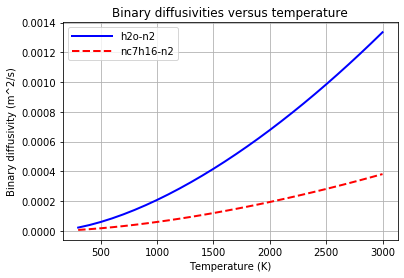

In [18]:
# plot binary diffusivities as functions of temperature
fig, ax = plt.subplots()
ax.plot(temps, D_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(temps, D_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Binary diffusivity (m^2/s)',
       title ='Binary diffusivities versus temperature')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DAB_vs_T.pdf")

The diffusivity for water vapor into nitrogen is higher than the diffusivity of n-heptane into nitrogen, and both diffusivities increase with increasing temperature. We will discuss this behavior further in Chapter 7. We can check the temperature scaling given in Equation 3.18b as follows:

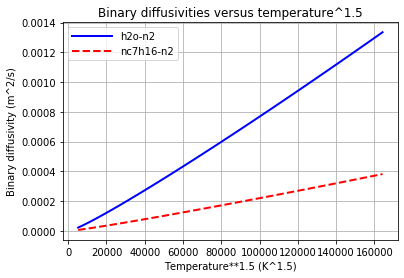

In [19]:
# plot binary diffusivities as functions of temperature^1.5  
fig, ax = plt.subplots()
ax.plot(temps**1.5, D_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(temps**1.5, D_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature**1.5 (K^1.5)',
       ylabel='Binary diffusivity (m^2/s)',
       title ='Binary diffusivities versus temperature^1.5')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DAB_vs_T1.5.pdf")

The variation is very close to linear, confirming the $T^{1.5}$ scaling given in Equation 3.18b.

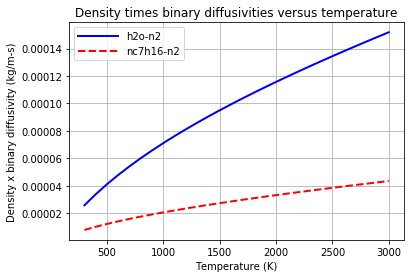

In [20]:
# plot density times binary diffusivities as functions of temperature
fig, ax = plt.subplots()
ax.plot(temps, rhoD_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(temps, rhoD_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature (K)',
       ylabel='Density x binary diffusivity (kg/m-s)',
       title ='Density times binary diffusivities versus temperature')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("rhoDAB_vs_T.pdf")

Check the scaling given in Equation 3.18c:

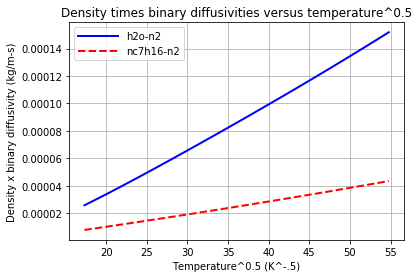

In [21]:
# plot density times binary diffusivities as functions of temperature^0.5   
fig, ax = plt.subplots()
ax.plot(temps**0.5, rhoD_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(temps**0.5, rhoD_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Temperature^0.5 (K^-.5)',
       ylabel='Density x binary diffusivity (kg/m-s)',
       title ='Density times binary diffusivities versus temperature^0.5')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("rhoDAB_vs_T0.5.pdf")

The square-root-of-temperature scaling is confirmed.

Now repeat the exercise, looking at how diffusivities vary with pressure:

In [22]:
# consider the pressure dependence at a fixed temperature of 300 K
temp = 300.

# set the pressure range and increment in atm
pmin = 0.1
pmax = 100.01
pinc = 0.1

press = np.arange(pmin,pmax,pinc)
npr   = len(press)

D_h2o_n2       = np.zeros(npr)
D_nc7h16_n2    = np.zeros(npr)
rhoD_h2o_n2    = np.zeros(npr)
rhoD_nc7h16_n2 = np.zeros(npr)

for i , pres in enumerate(press):
    gas.TP            = temp , pres*ct.one_atm # convert to Pa
    D_h2o_n2[i]       = gas.binary_diff_coeffs[ih2o,in2]
    D_nc7h16_n2[i]    = gas.binary_diff_coeffs[inc7h16,in2]
    rhoD_h2o_n2[i]    = gas.density*gas.binary_diff_coeffs[ih2o,in2]
    rhoD_nc7h16_n2[i] = gas.density*gas.binary_diff_coeffs[inc7h16,in2]

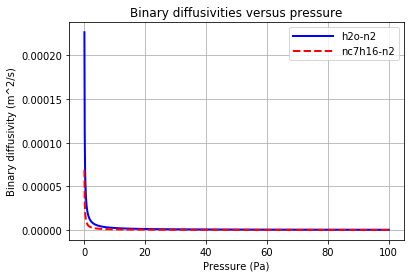

In [23]:
# plot binary diffusivities as functions of pressure
fig, ax = plt.subplots()
ax.plot(press, D_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(press, D_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Pressure (Pa)',
       ylabel='Binary diffusivity (m^2/s)',
       title ='Binary diffusivities versus pressure')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DAB_vs_p.pdf")

Check the pressure scaling given in Equation 3.18b.

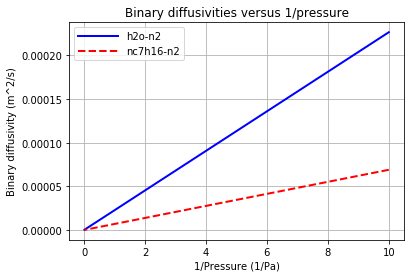

In [24]:
# plot binary diffusivities as functions of 1/pressure
fig, ax = plt.subplots()
ax.plot(1./press, D_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(1./press, D_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='1/Pressure (1/Pa)',
       ylabel='Binary diffusivity (m^2/s)',
       title ='Binary diffusivities versus 1/pressure')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DAB_vs_p-1.pdf")

The inverse-pressure scaling is confirmed.

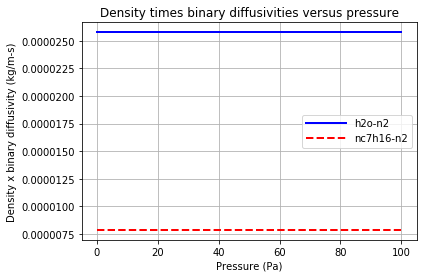

In [25]:
# plot density times binary diffusivities as functions of pressure
fig, ax = plt.subplots()
ax.plot(press, rhoD_h2o_n2,    label='h2o-n2',    linestyle='solid',  color='blue', lw=2)
ax.plot(press, rhoD_nc7h16_n2, label='nc7h16-n2', linestyle='dashed', color='red',  lw=2)
ax.set(xlabel='Pressure (Pa)',
       ylabel='Density x binary diffusivity (kg/m-s)',
       title ='Density times binary diffusivities versus pressure')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("rhoDAB_vs_p.pdf")

This confirms that the product of mixture density and binary diffusivity is independent of pressure.

## 5. What's next

Molecular transport properties will be discussed further in Chapter 7 and in an associated tutorial Notebook. Droplet vaporization and combustion will be discussed in Chapter 10.